In [1]:
import os
os.chdir('/grid_mnt/data_cms_upgrade/biriukov/TICL_Validation/python')
from validation.DataFile import *
from typing import List, Union
from scipy.optimize import curve_fit

# for plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
#plt.rcParams['text.usetex'] = True
import mplhep as hep
plt.style.use(hep.style.CMS)
filepath = '/grid_mnt/data_cms_upgrade/biriukov/data/photons_D110_E_5_30/step3_no_PU/14_2_0_pre1/dumper/dumper_merged.root'
#filepath = '/grid_mnt/data_cms_upgrade/biriukov/data/photons_D110_E_10_1000/step3_no_PU/14_2_0_pre1/dumper/dumper_merged.root'

tfile = DataFile(filepath)

In [26]:
# data processing
def getResponseInBins(seed_energy: List[float], e_bins: int, n_bins: int, binning_opt: str=None, opt_map: List[bool] = None):
    # seed_energy is energy range of generated sample's config [E_min, E_max]

    # Extract energy arrays of seeds and reco objects
    e_gen = ak.flatten(tfile.openArray(branch_name="ticlDumper/simtrackstersCP", key="raw_energy"))
    e_reco = tfile.openArray(branch_name="ticlDumper/trackstersCLUE3DHigh", key="regressed_energy")

    # Extract simToReco association
    simToReco = tfile.openArray(branch_name="ticlDumper/associations", key="tsCLUE3D_simToReco_CP")[:, 0]
    # Order reco object with 'best associated' criterion
    e_reco = e_reco[simToReco][:, 0]

    # Apply additional maps if required
    if opt_map is not None:
        e_gen = e_gen[opt_map]
        e_reco = e_reco[opt_map]

    # Compute response
    response = e_reco/e_gen

    # Cut the energy tails
    cut_map = (e_gen > seed_energy[0]) & (e_gen < seed_energy[1])
    response = response[cut_map]
    e_gen = e_gen[cut_map]

    # Make log scale bin edges 
    e_gen_min = np.min(e_gen)
    e_gen_max = np.max(e_gen)
    if binning_opt == 'log':
        e_gen_bin_edges = np.logspace(np.log10(e_gen_min), np.log10(e_gen_max), e_bins)
    else:
        e_gen_bin_edges = np.linspace(e_gen_min, e_gen_max, e_bins)

    # Make a list of energy response values for each E_gen bin
    response_in_e_gen_bins = []
    for bin in range(len(e_gen_bin_edges) - 1):
        bin_map = (e_gen > e_gen_bin_edges[bin]) & (e_gen < e_gen_bin_edges[bin + 1])
        response_in_e_gen_bins.append(response[bin_map])

    # Make a histogram for each response array
    response_min = np.min(response)
    response_max = np.max(response)
    response_histograms = []
    response_bins = np.linspace(0.8, response_max, n_bins)
    for response in response_in_e_gen_bins:
        histogram, _ = np.histogram(np.array(response), response_bins)
        response_histograms.append(histogram)    

    return response_histograms, response_bins, e_gen_bin_edges

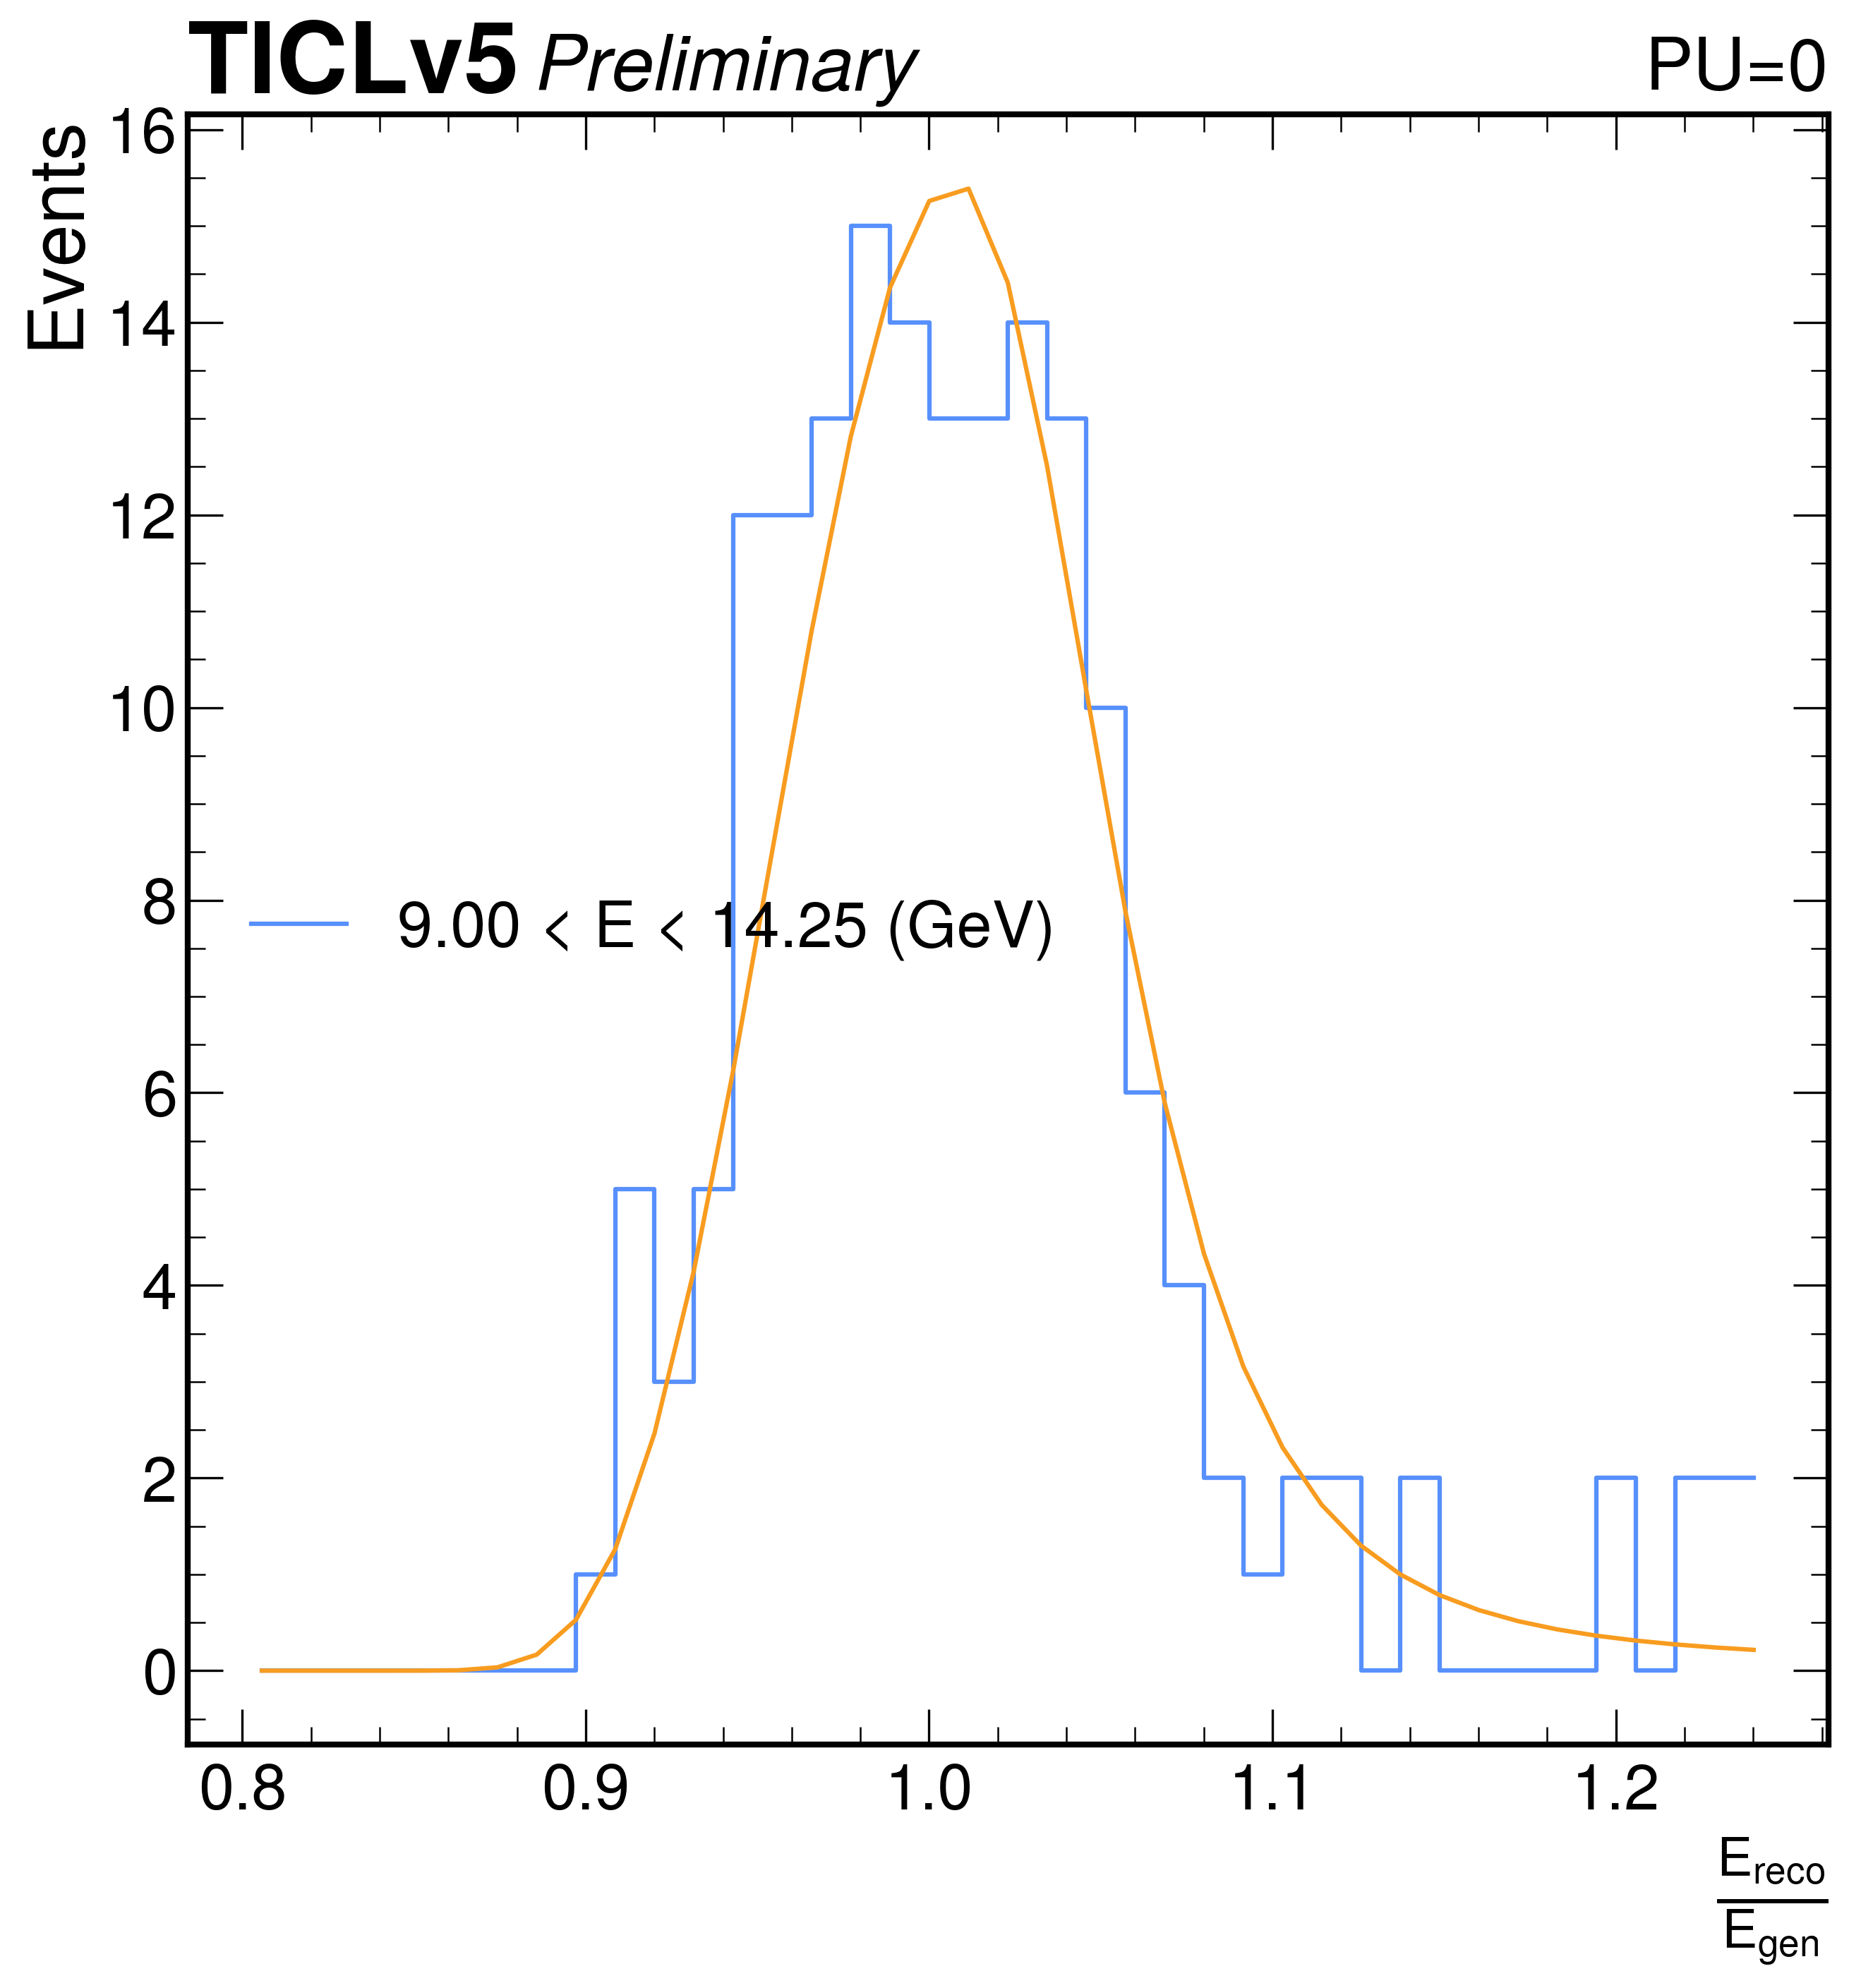

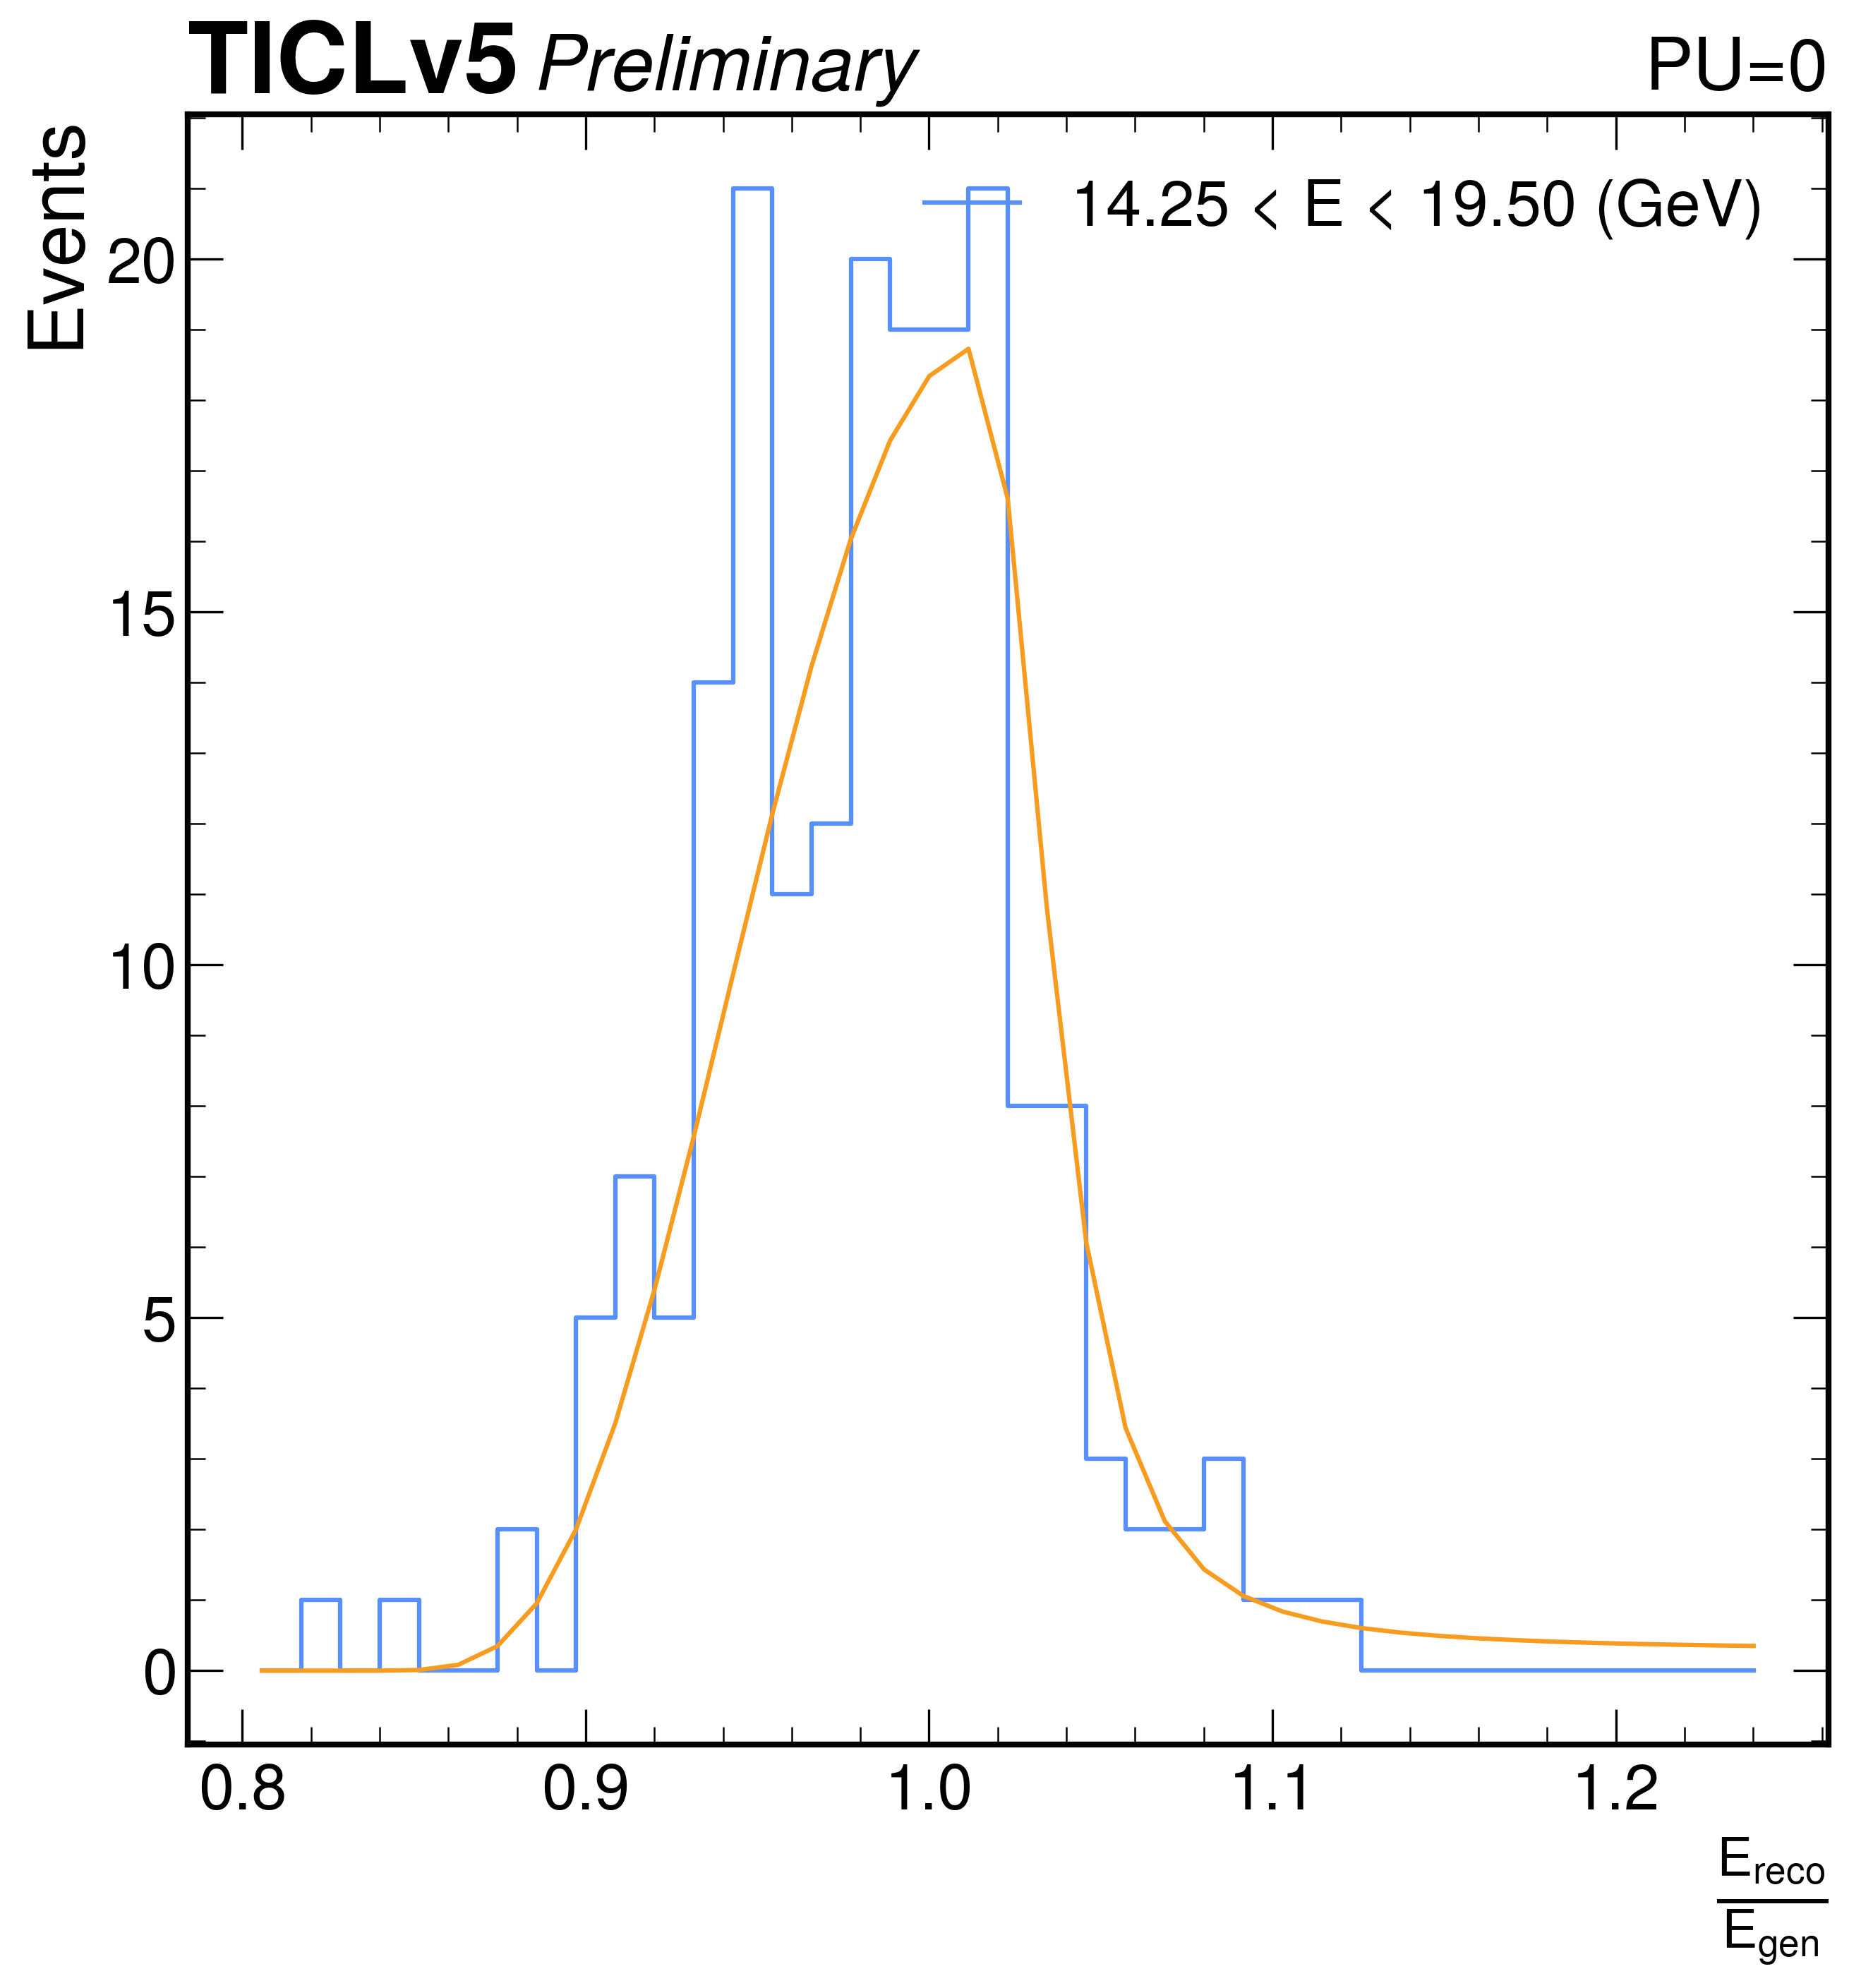

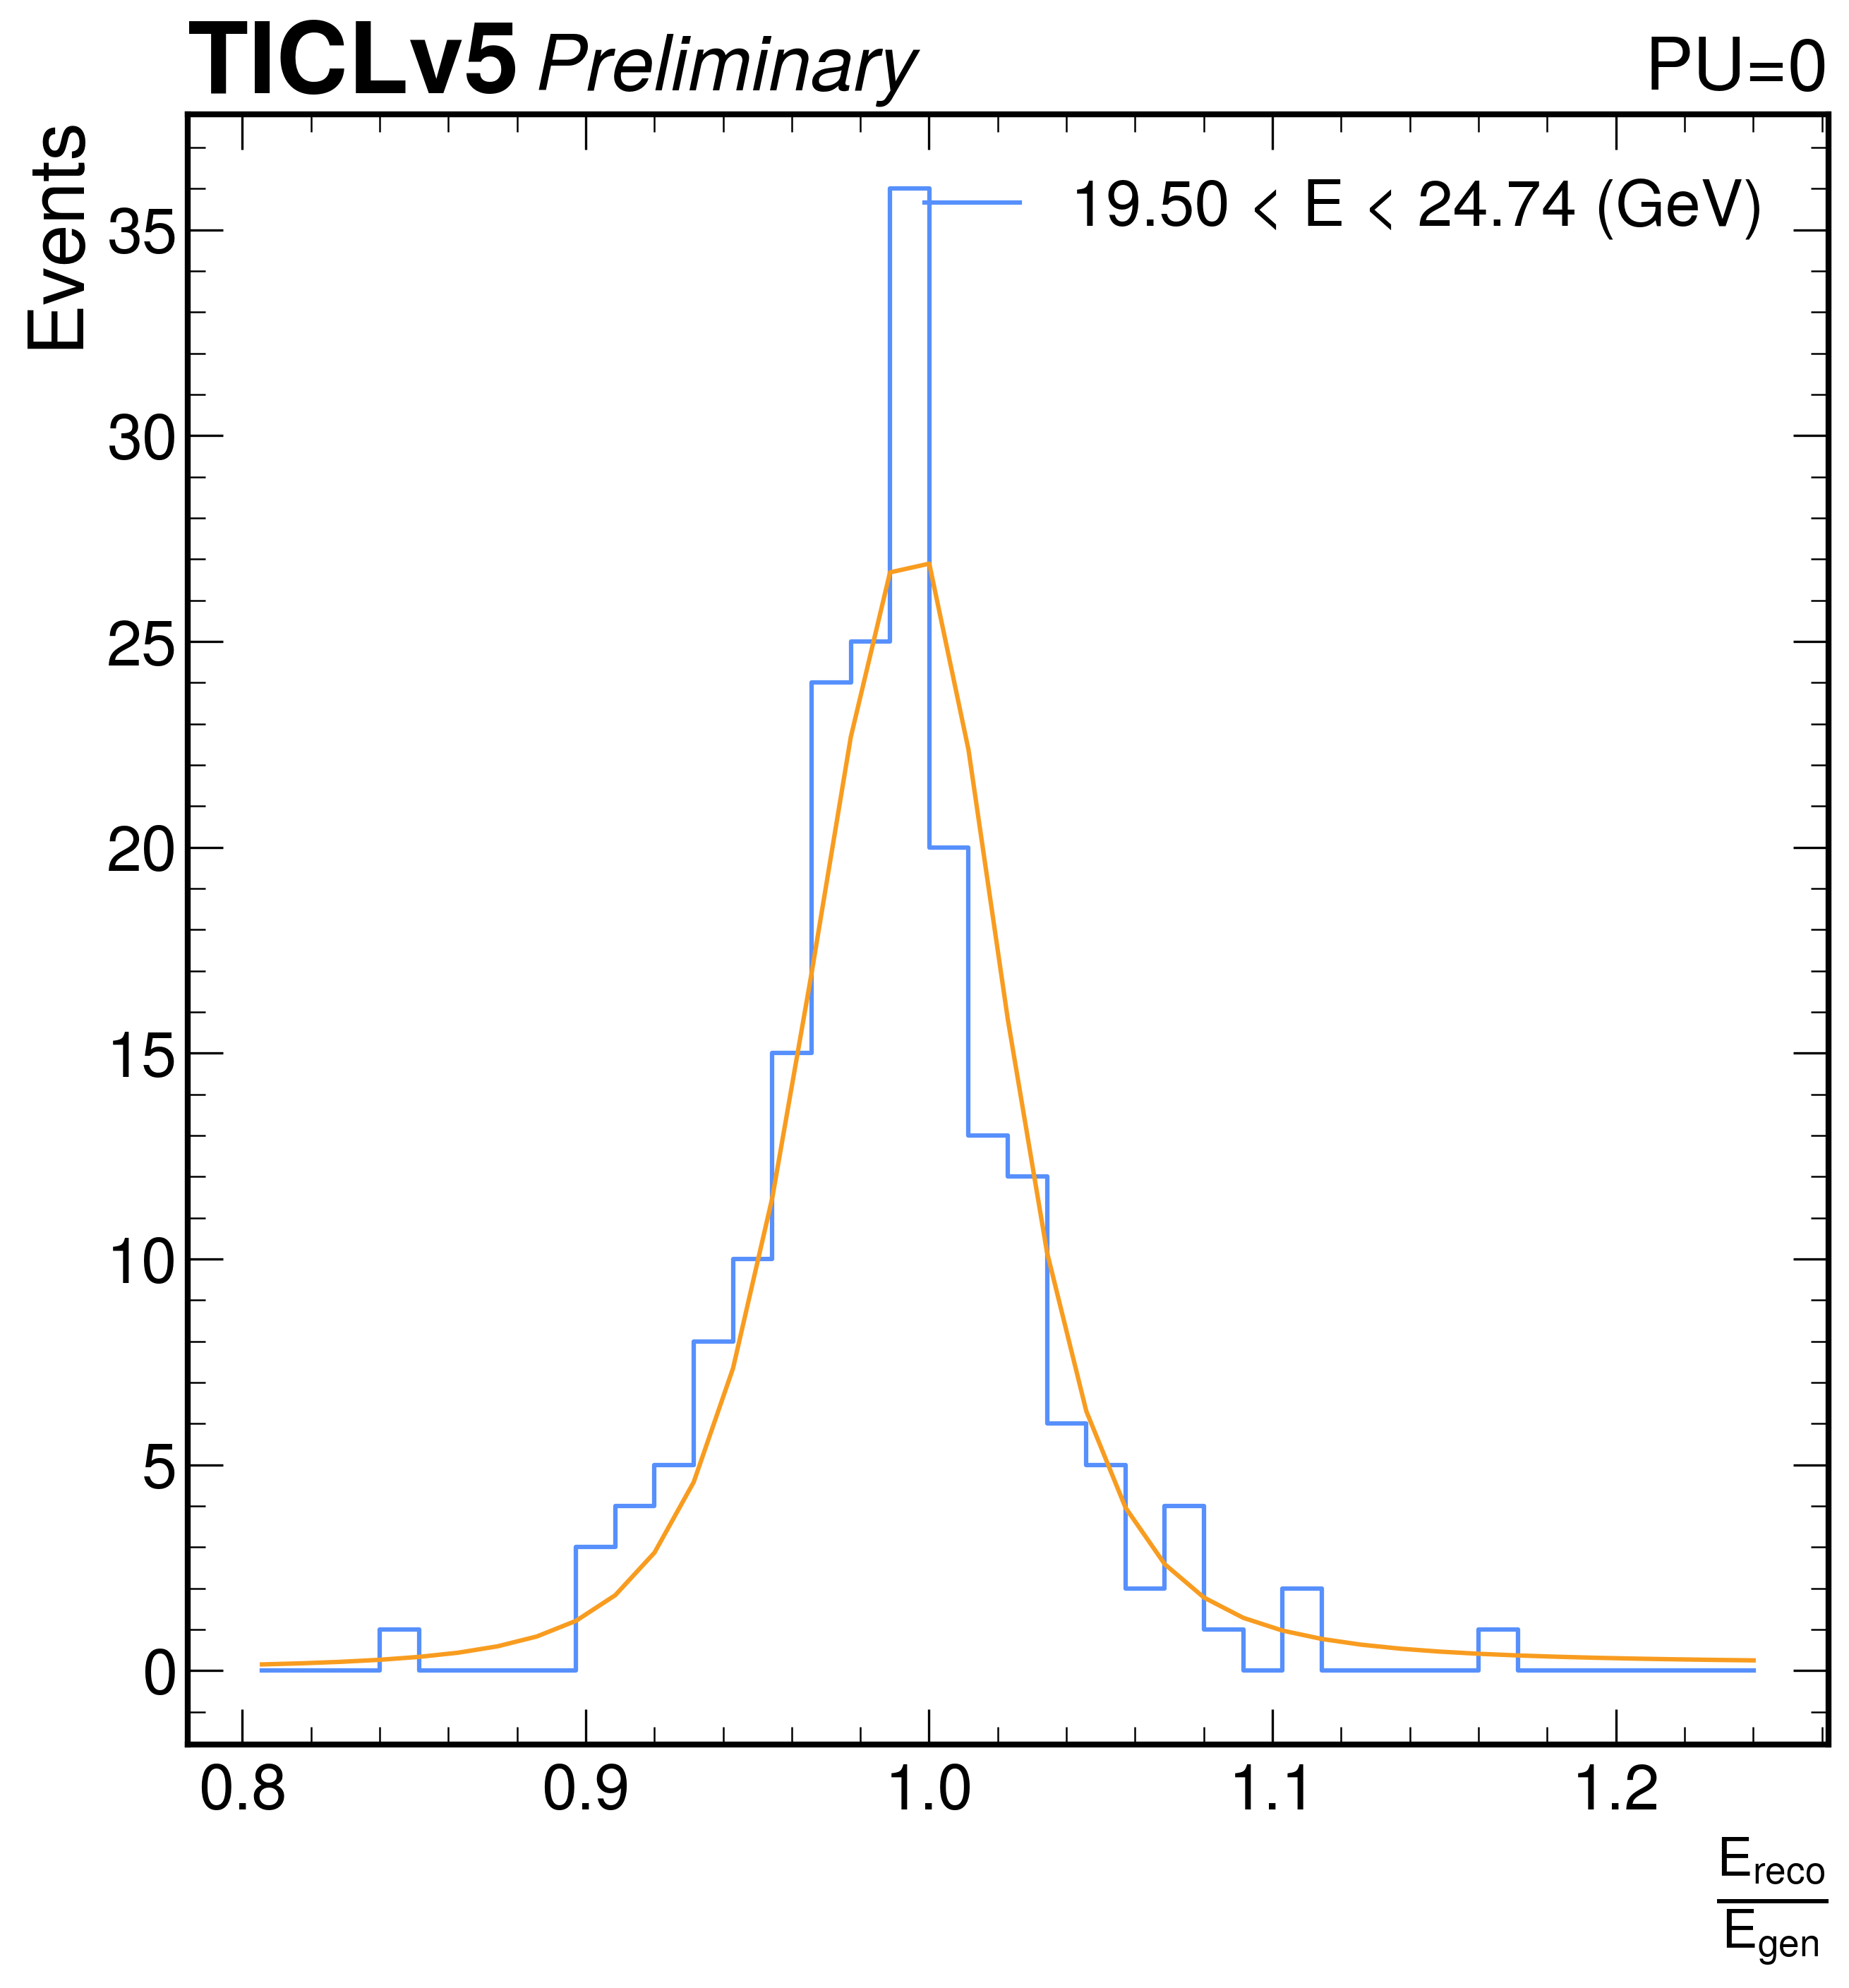

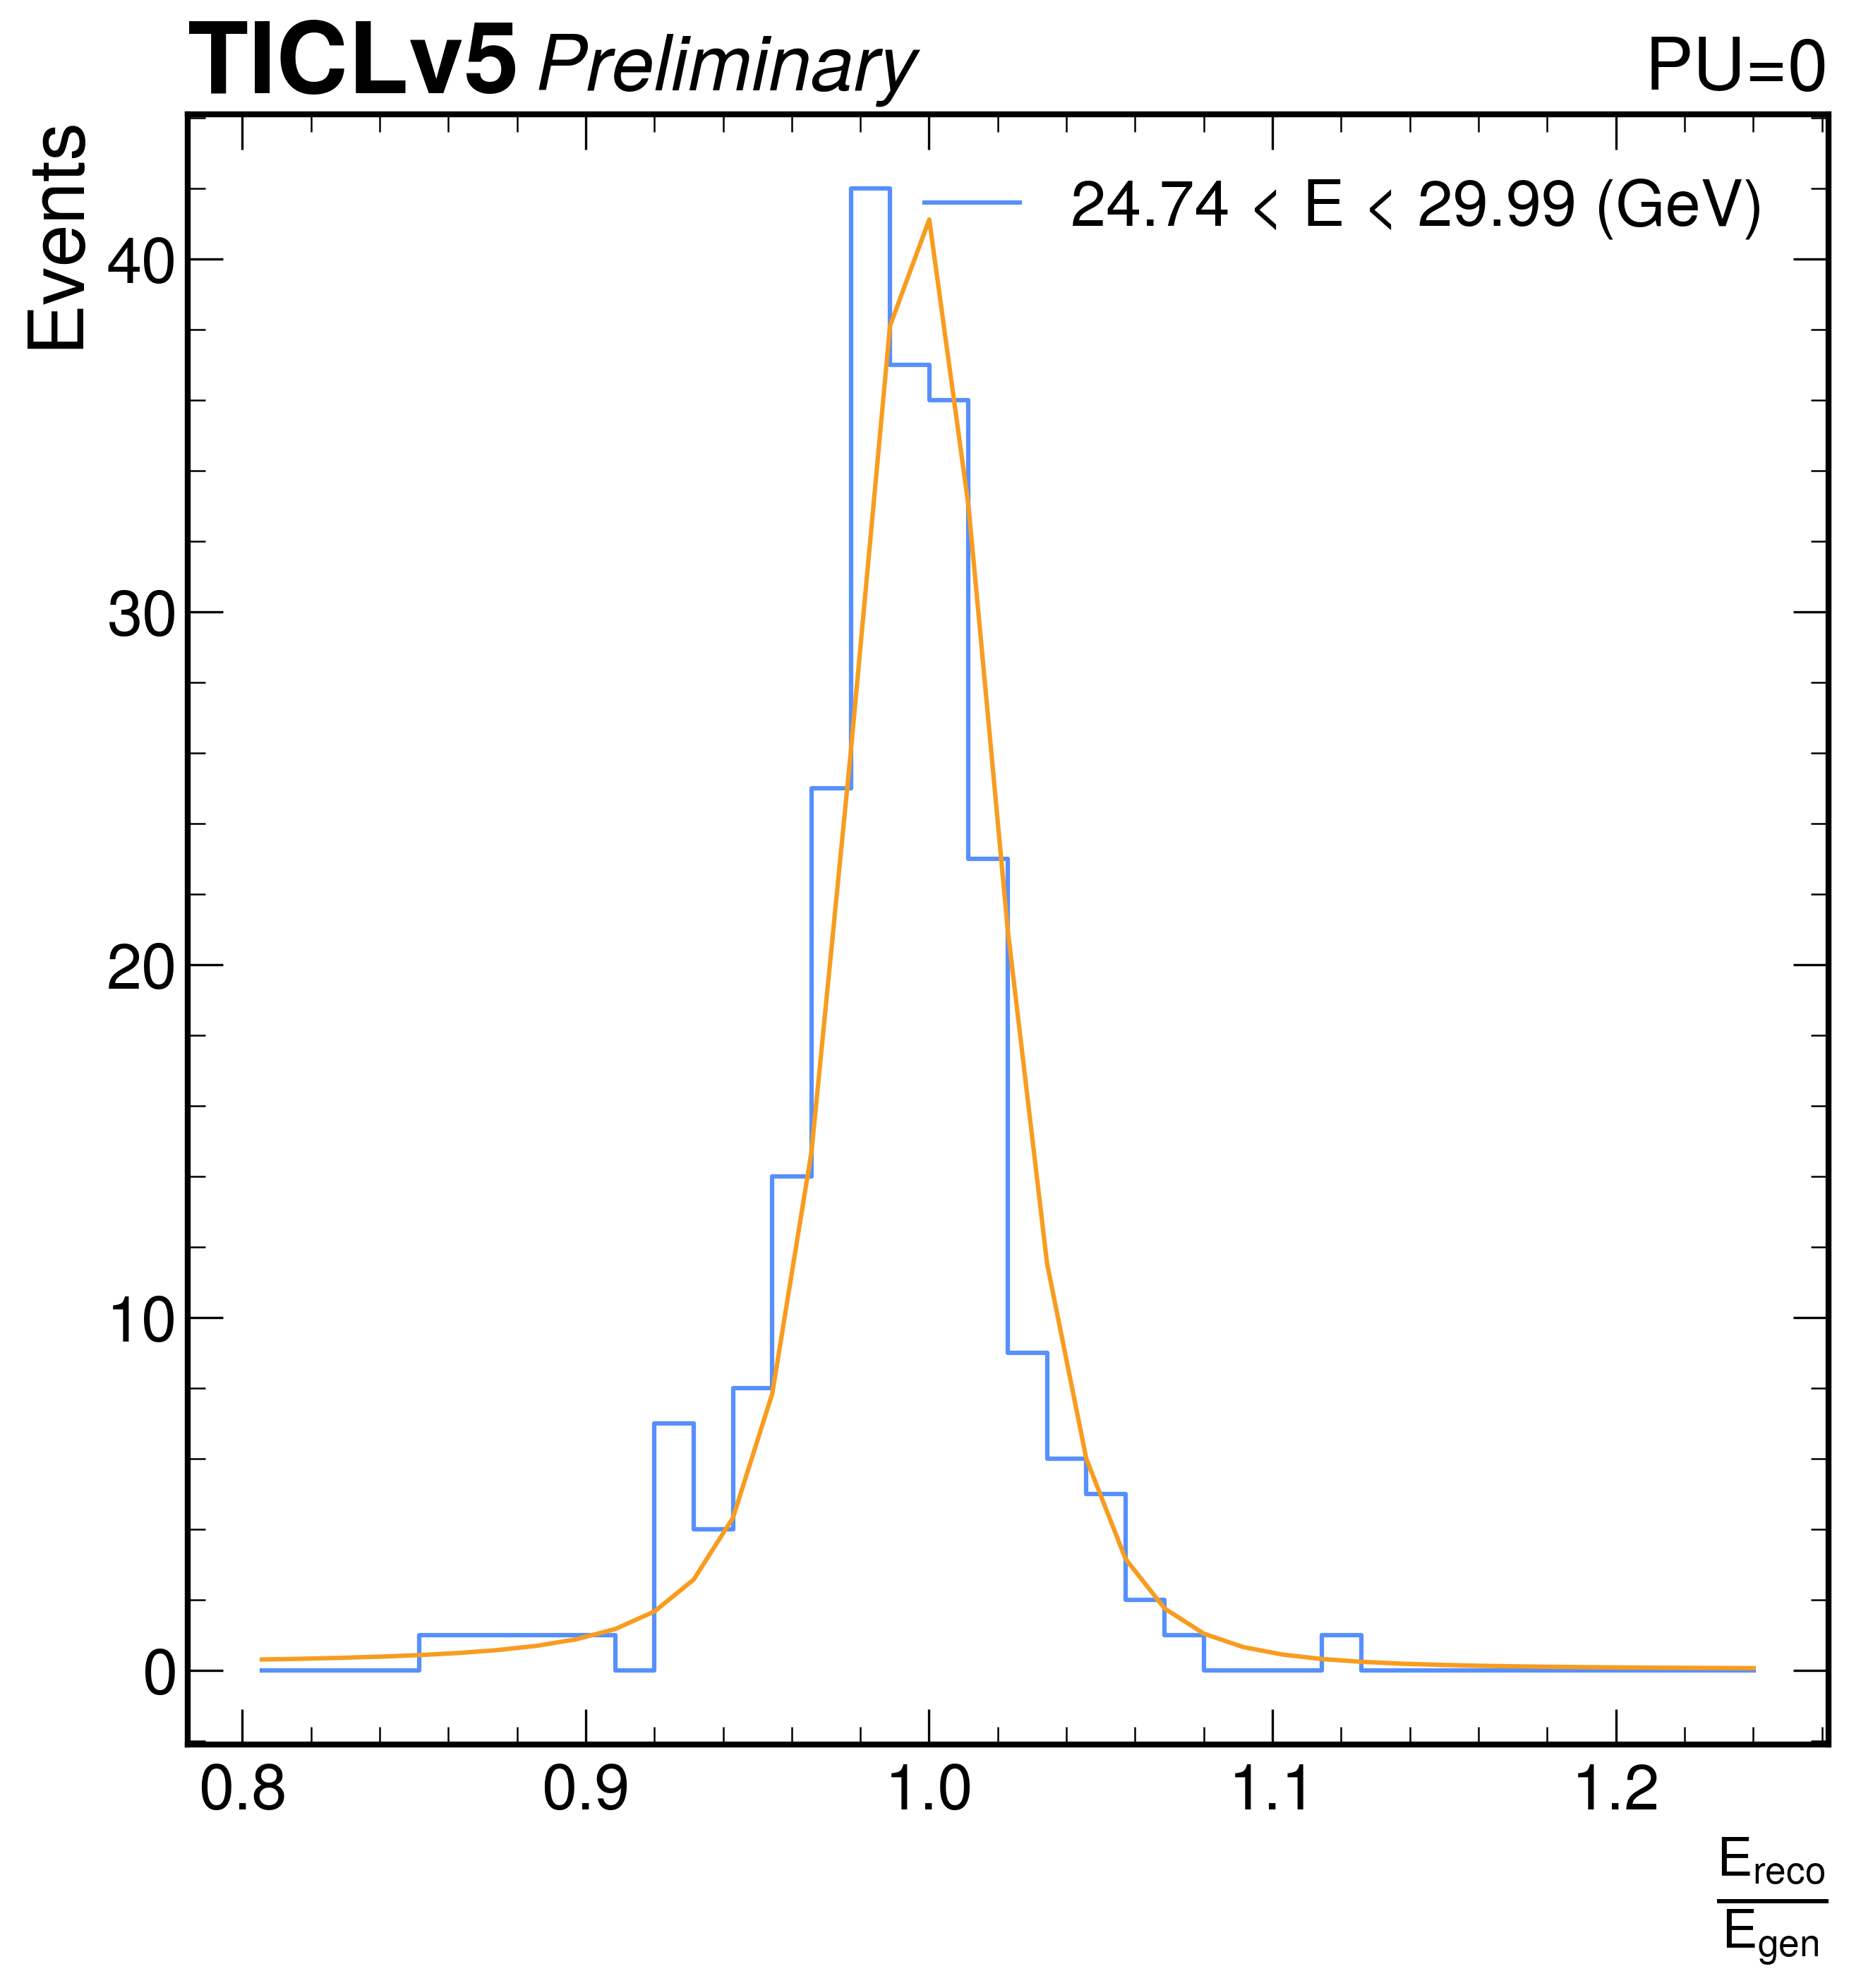

In [61]:
hists = hists_hd
po = po_hd

for i in range(len(hists[0])):
    fig, ax = plt.subplots()

    hist_bins = hists[1]
    bin_centers = (hist_bins[1:] + hist_bins[:-1])/2

    min_e = hists[2][i]
    max_e = hists[2][i + 1]
    hist_label = f'{min_e:.2f} < E < {max_e:.2f} (GeV)'
    ax.step(bin_centers, hists[0][i], label=hist_label)
    ax.plot(bin_centers, cruijff(bin_centers, *po[i]))
    ax.set_xlabel(r'$\frac{E_\text{reco}}{E_\text{gen}}$')
    ax.set_ylabel('Events')
    ax.legend()
    hep.cms.text("Preliminary", exp="TICLv5", ax=ax)
    hep.cms.lumitext("PU=0", ax=ax)

    hist_name = hist_label.replace(' < ', '').replace(' (GeV)', '')
    hist_name = 'fit_' + hist_name + '_HD'
    path_to_save = 'plots/resolution'
    os.makedirs(path_to_save, exist_ok=True)
    plt.savefig(f'{path_to_save}/{hist_name}.png')
    

In [3]:
# functions for fitting
def cruijff(x, A, m, sigmaL, sigmaR, alphaL, alphaR):
    dx = (x-m)
    SL = np.full(x.shape, sigmaL)
    SR = np.full(x.shape, sigmaR)
    AL = np.full(x.shape, alphaL)
    AR = np.full(x.shape, alphaR)
    sigma = np.where(dx<0, SL,SR)
    alpha = np.where(dx<0, AL,AR)
    f = 2*sigma*sigma + alpha*dx*dx
    return A* np.exp(-dx*dx/f)

def histogram_quantiles(hist: List[float],
                       hist_bins: List[float],
                       quantiles: List[float]):
    cdf = (np.cumsum(hist) - 0.5 * hist) / np.sum(hist)
    bin_centers = (hist_bins[1:] + hist_bins[:-1])/2
    return np.interp(quantiles, cdf, bin_centers)

def fitFunc(hist: List[float],
            hist_bins: List[float],
            func):
    bin_centers = (hist_bins[1:] + hist_bins[:-1])/2
    mean = np.average(bin_centers, weights=hist)
    q_min2, q_min1, median, q_plus1, q_plus2 = histogram_quantiles(hist, hist_bins, [0.5-0.95/2, 0.5-0.68/2, 0.5, 0.5+0.68/2, 0.5+0.95/2])

    p0 = [
        np.max(hist), # normalization. The 0.8 is because it seems that the max value is usually a bit higher
        mean, # central value
        median-q_min1, #sigmaL : this quantile difference is 1sigma for a Gaussian
        q_plus1-median, # sigmaR
        (q_min1-q_min2) / (median-q_min1)/3.81 * 0.28067382, #alphaL : in the ratio, numerator and denominator should be sigma for a gaussian. Otherwise, the heavier the tails, the higher from one. Then some norm coefficient (could be improved)
        (q_plus2-q_plus1) / (q_plus1-median)/3.81 * 0.28067382 #alphaR 
    ] 

    try:
        param_optimised,param_covariance_matrix = curve_fit(func, bin_centers, hist, 
            p0=p0, sigma=np.maximum(np.sqrt(hist), 1.8), absolute_sigma=True, maxfev=500000,
            bounds=np.transpose([(0., np.inf), (-np.inf, np.inf), (0., np.inf), (0., np.inf), (-np.inf, np.inf), (-np.inf, np.inf)])
            )
    except ValueError: # sometimes it fails with ValueError: array must not contain infs or NaNs and removing bounds helps
        param_optimised,param_covariance_matrix = curve_fit(func, bin_centers, hist, 
            p0=p0, sigma=np.maximum(np.sqrt(hist), 1.8), absolute_sigma=True, maxfev=500000,
            #bounds=np.transpose([(0., np.inf), (-np.inf, np.inf), (0., np.inf), (0., np.inf), (-np.inf, np.inf), (-np.inf, np.inf)])
            )
    return param_optimised, param_covariance_matrix

def fitMultFunc(hists: List[List[float]],
                hist_bins: List[float],
                func):
    param_optimized = []
    for hist in hists:
        po, cov = fitFunc(hist, hist_bins, func)
        param_optimized.append(po)
    
    return param_optimized

In [4]:
# optional maps
barycenter_eta = tfile.openArray(branch_name="ticlDumper/trackstersCLUE3DHigh", key="barycenter_eta")[:, 0]

hd_map = barycenter_eta < 2.02
ld_map = barycenter_eta > 2.02

In [53]:
hists_hd = getResponseInBins([5, 30], 5, 40, None, hd_map)
po_hd = fitMultFunc(hists_hd[0], hists_hd[1], cruijff)

hists_ld = getResponseInBins([5, 30], 5, 40, None, ld_map)
po_ld = fitMultFunc(hists_ld[0], hists_ld[1], cruijff)

/tmp/ipykernel_1234862/2344542333.py:11: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)


In [55]:
mu_hd = []
for params in po_hd:
    mu_hd.append(params[1])

mu_ld = []
for params in po_ld:
    mu_ld.append(params[1])

In [56]:
sigma_average_hd = []
for params in po_hd:
    sigma_average_hd.append((params[2] + params[3])/2)

sigma_average_ld = []
for params in po_ld:
    sigma_average_ld.append((params[2] + params[3])/2)

In [57]:
resolution_hd = np.array(sigma_average_hd)/np.array(mu_hd)
resolution_ld = np.array(sigma_average_ld)/np.array(mu_ld)

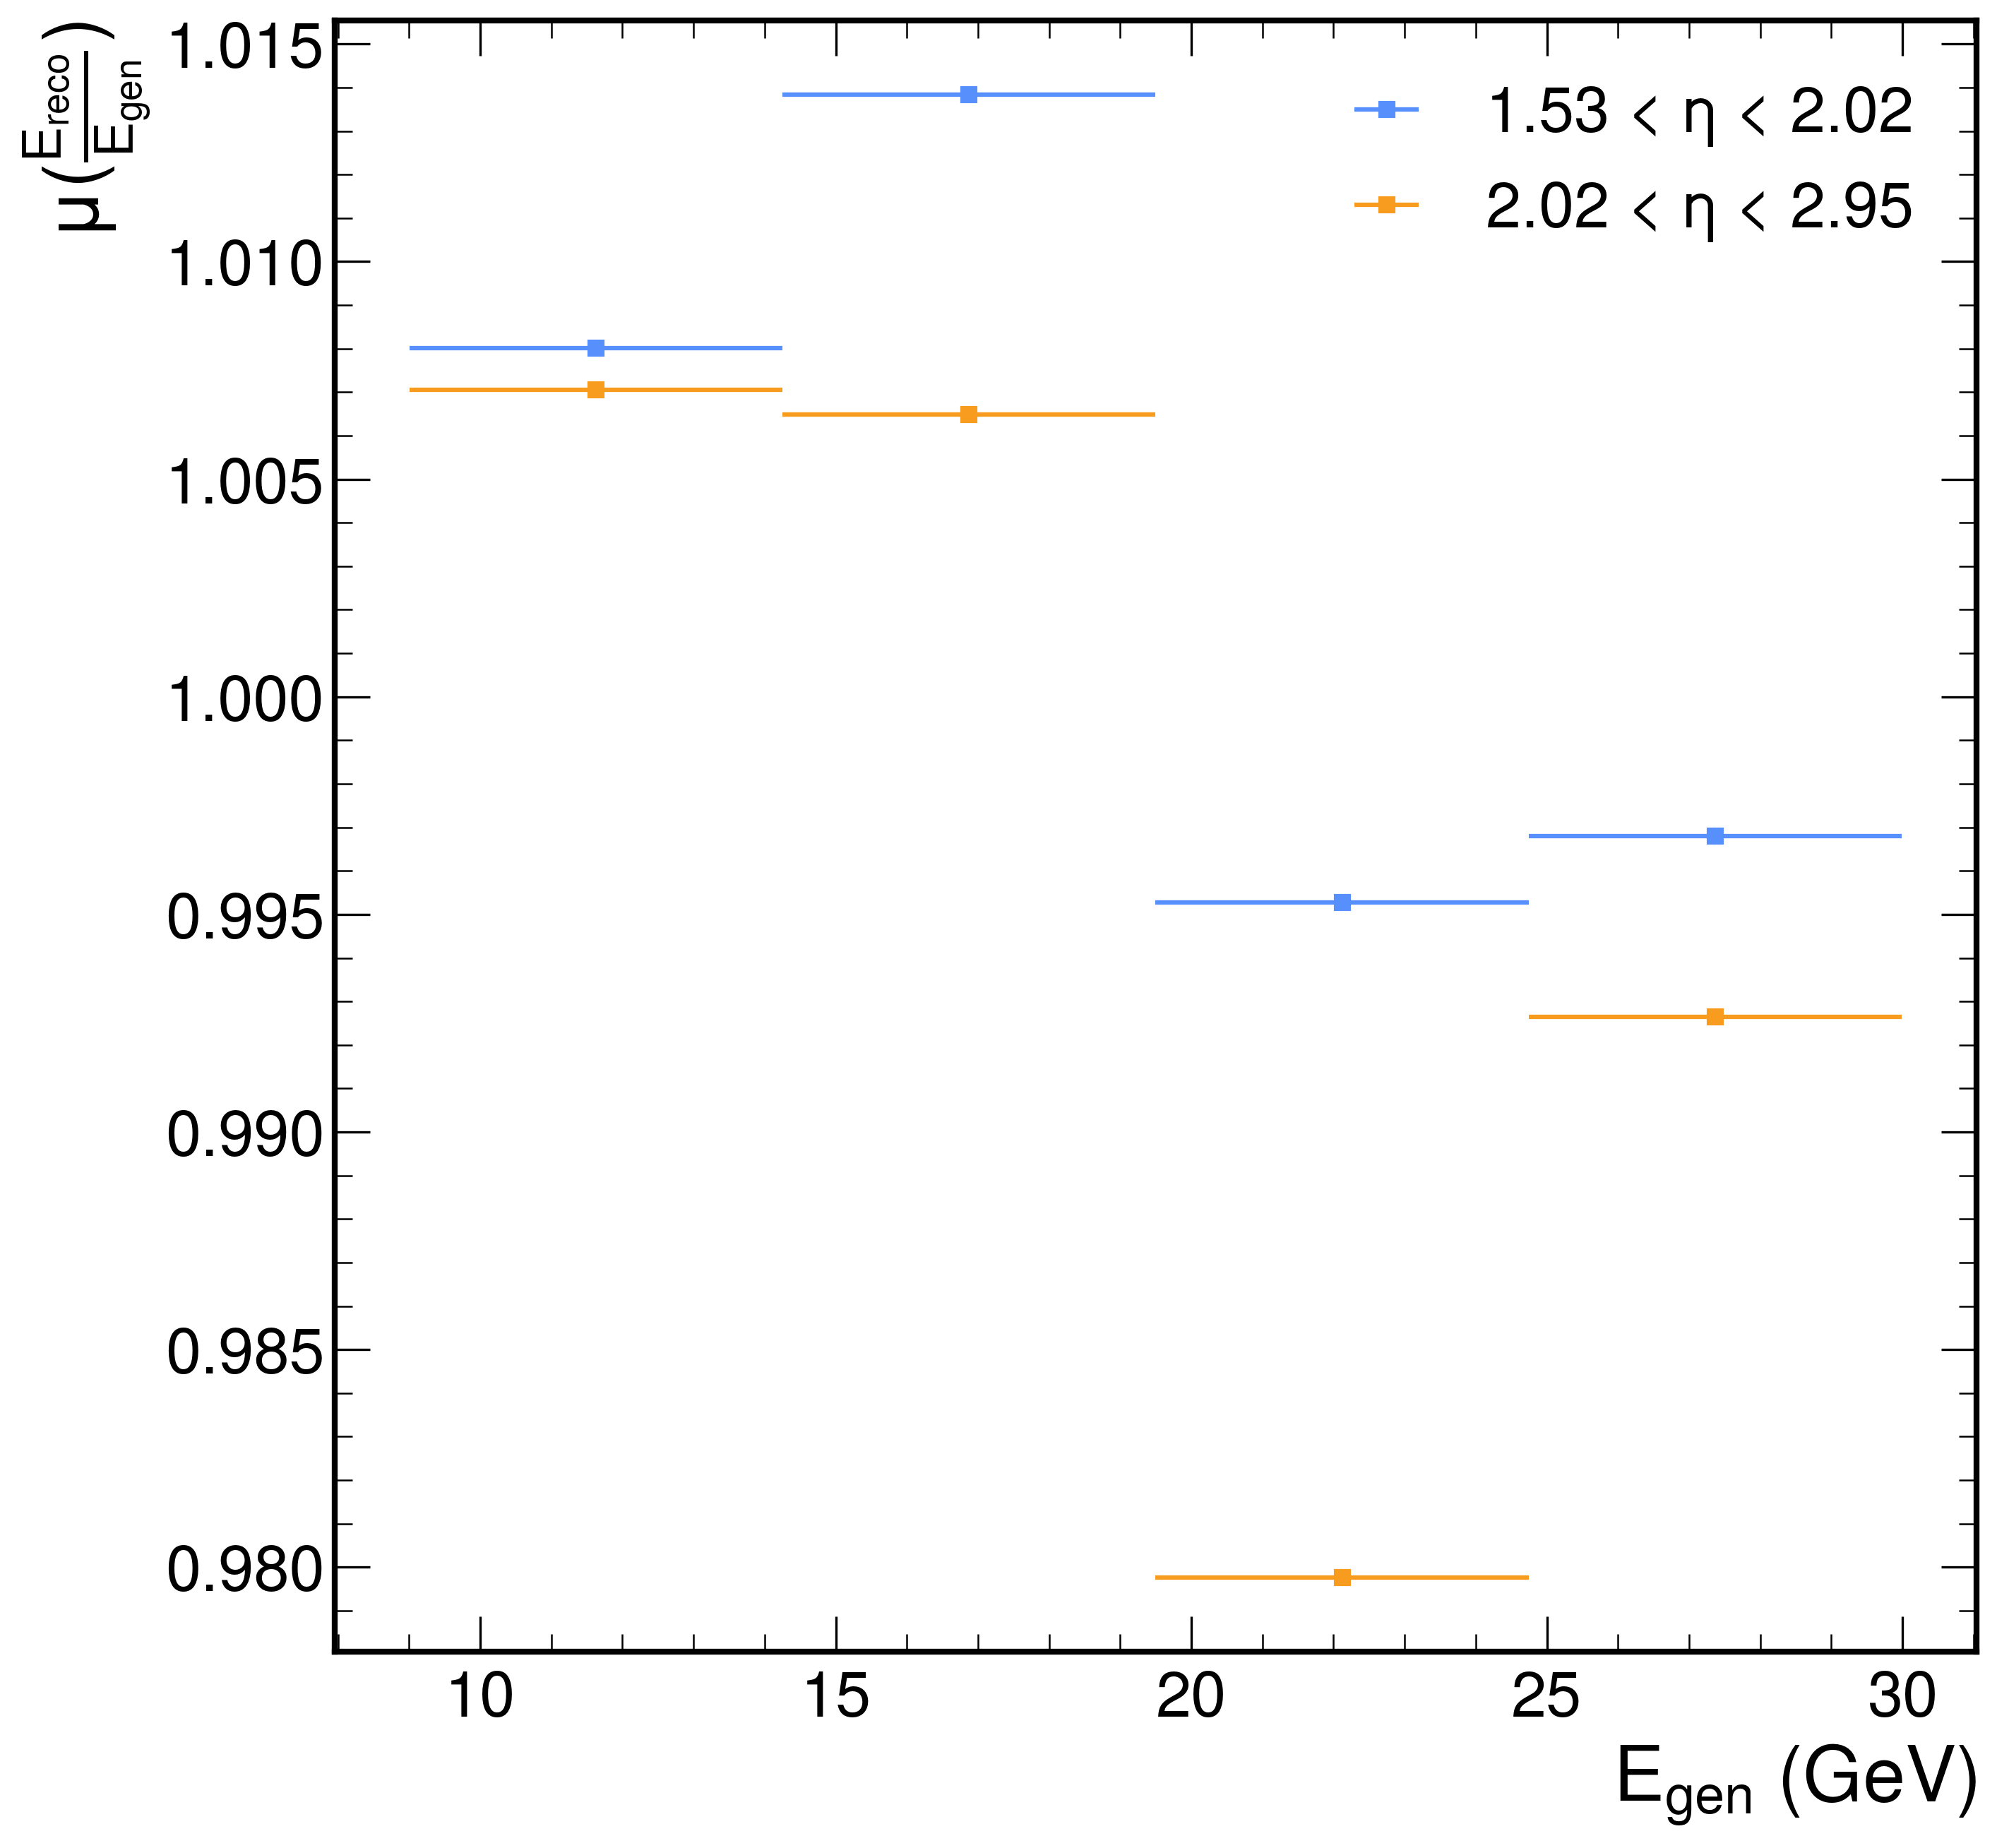

In [58]:
#mu plots

fig, ax = plt.subplots()

bin_edges = hists_hd[2]
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
bin_width = (bin_edges[1:] - bin_edges[:-1])/2

eta_min = np.min(barycenter_eta)
eta_max = np.max(barycenter_eta)
label_hd = rf'{eta_min:.2f} < $\eta$ < 2.02'
label_ld = rf'2.02 < $\eta$ < {eta_max:.2f}'

ax.errorbar(bin_centers, mu_hd, xerr = bin_width, ls='none', fmt='s', markersize=5, label=label_hd)
ax.errorbar(bin_centers, mu_ld, xerr = bin_width, ls='none', fmt='s', markersize=5, label=label_ld)
ax.set_xlabel(r'$E_\text{gen}$ (GeV)')
ax.set_ylabel(r'$\mu(\frac{E_\text{reco}}{E_\text{gen}})$')
ax.legend()

hist_name = 'mu_HD_LD_comparison'
path_to_save = 'plots/resolution/'
os.makedirs(path_to_save, exist_ok=True)
plt.savefig(f'{path_to_save}/{hist_name}.png')

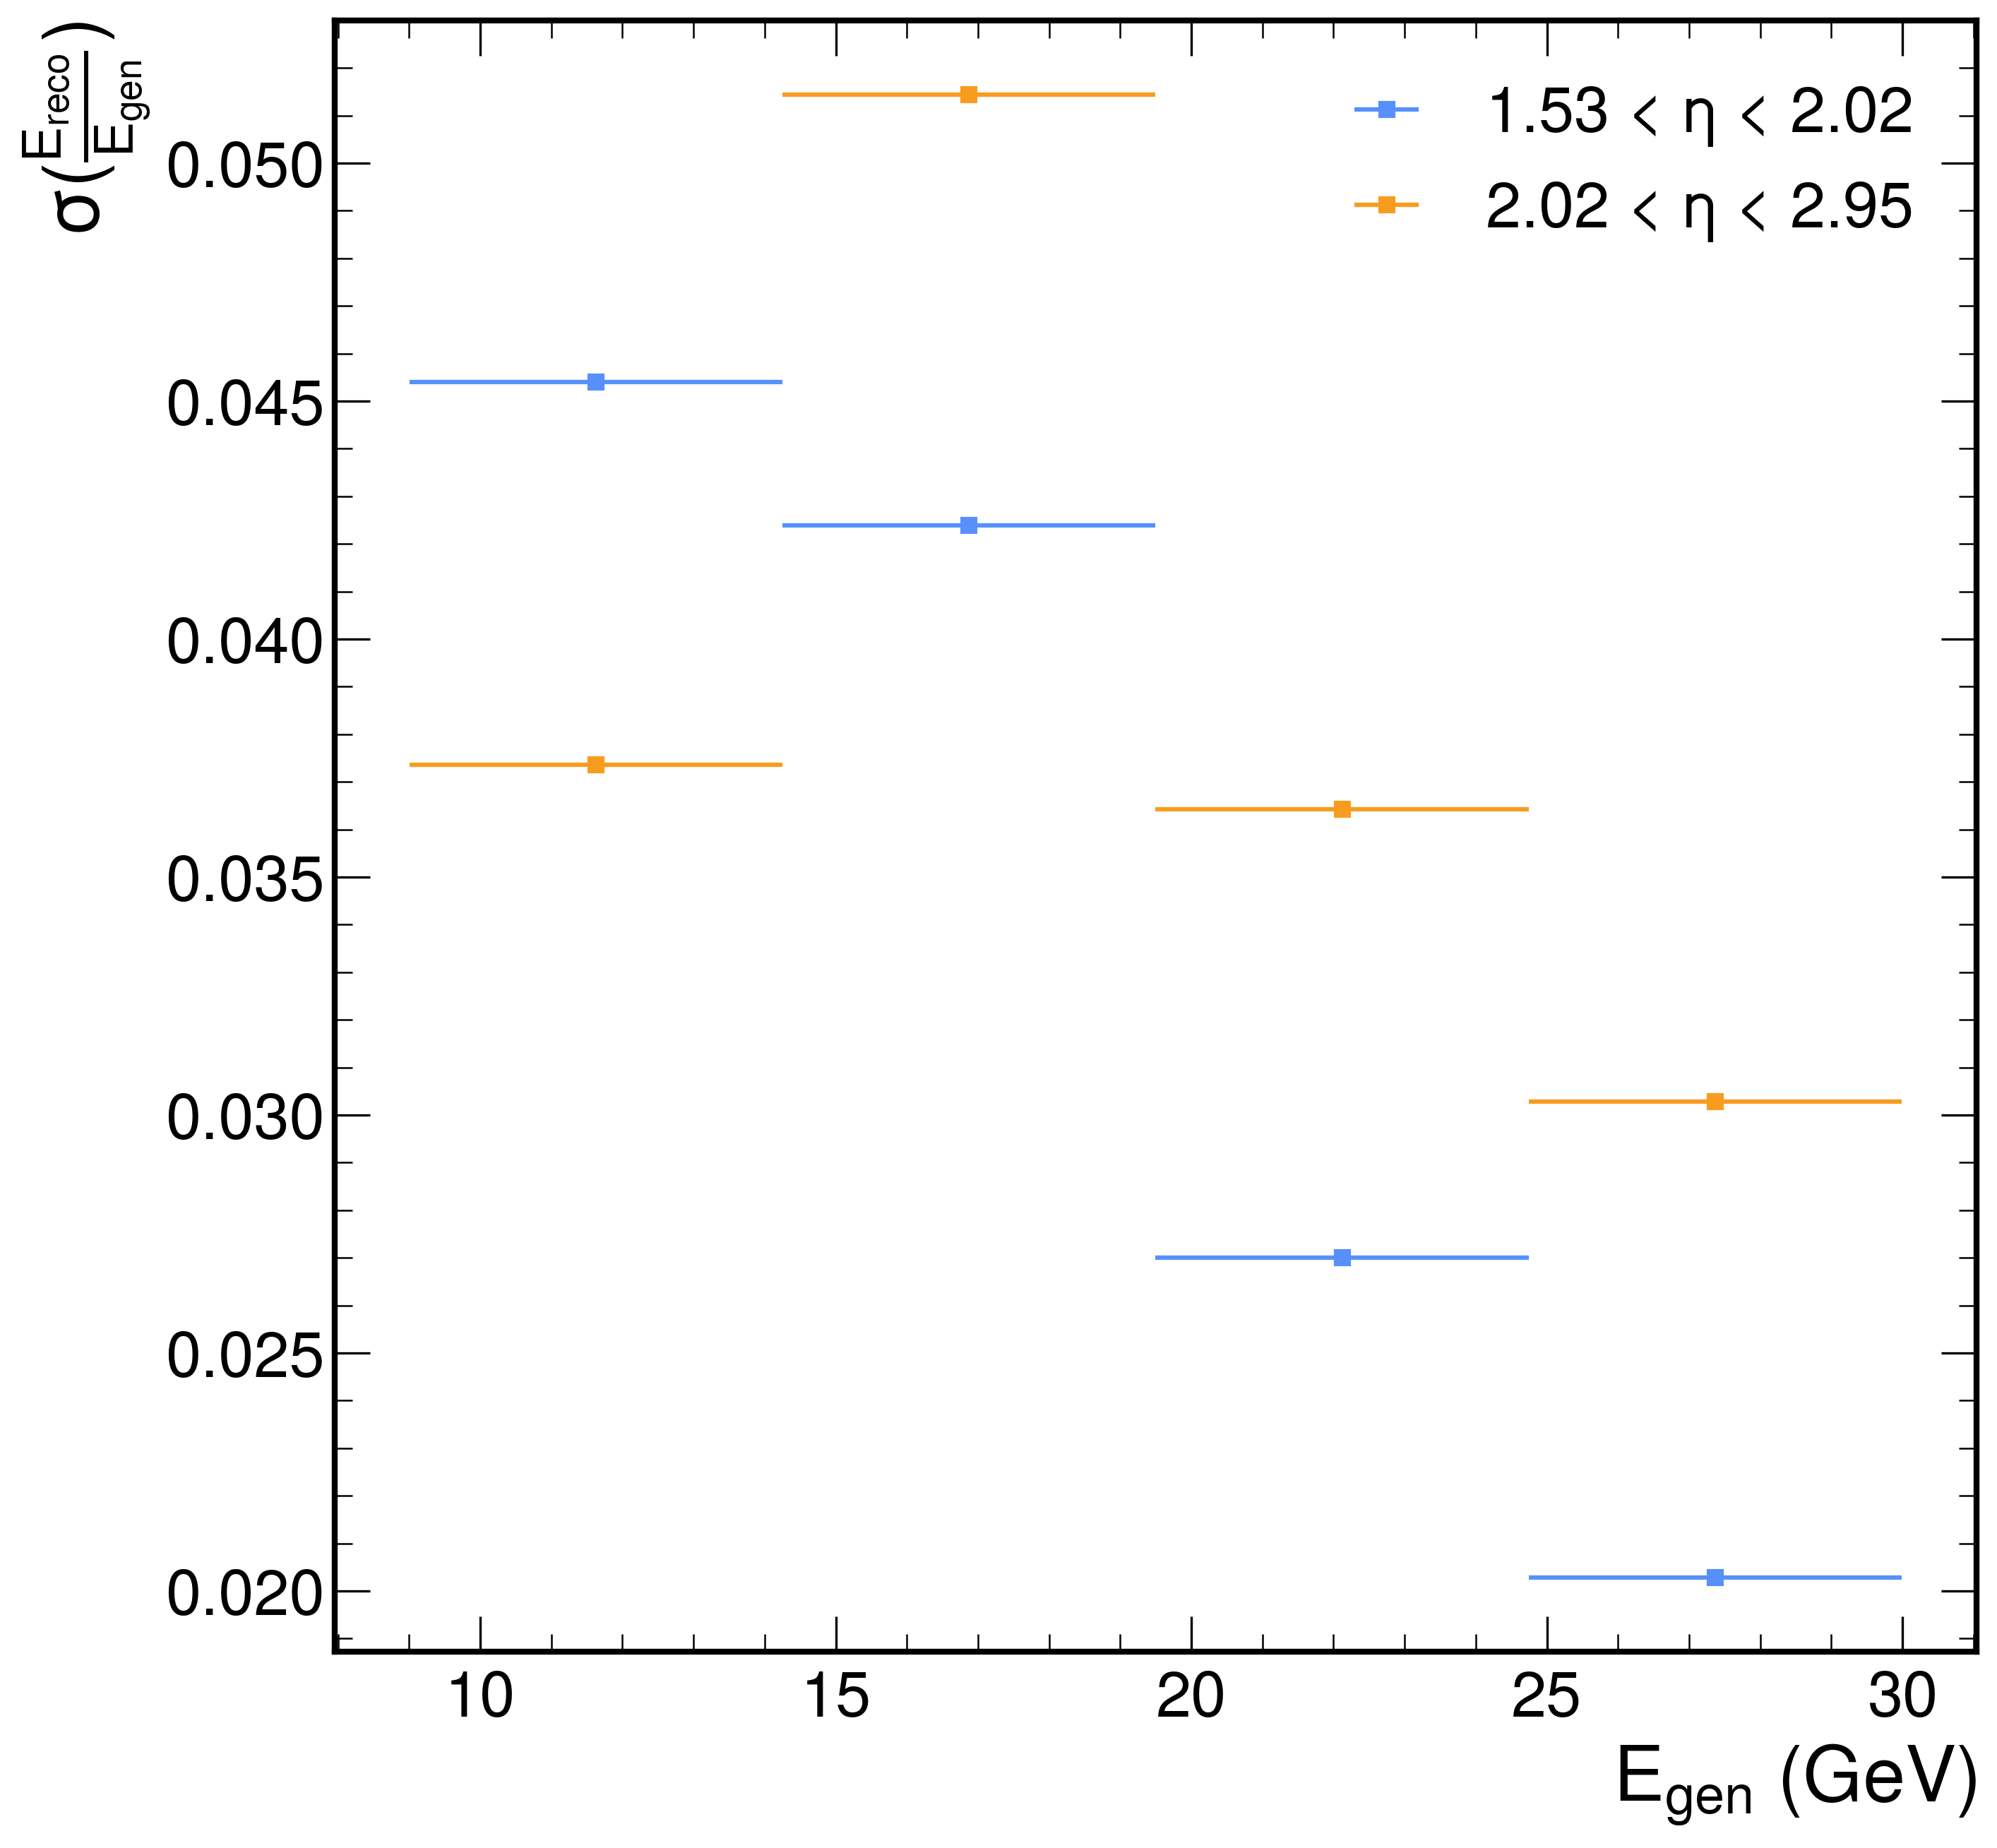

In [59]:
# sigma plots

fig, ax = plt.subplots()

bin_edges = hists_hd[2]
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
bin_width = (bin_edges[1:] - bin_edges[:-1])/2

eta_min = np.min(barycenter_eta)
eta_max = np.max(barycenter_eta)
label_hd = rf'{eta_min:.2f} < $\eta$ < 2.02'
label_ld = rf'2.02 < $\eta$ < {eta_max:.2f}'

ax.errorbar(bin_centers, sigma_average_hd, xerr = bin_width, ls='none', fmt='s', markersize=5, label=label_hd)
ax.errorbar(bin_centers, sigma_average_ld, xerr = bin_width, ls='none', fmt='s', markersize=5, label=label_ld)
ax.set_xlabel(r'$E_\text{gen}$ (GeV)')
ax.set_ylabel(r'$\sigma(\frac{E_\text{reco}}{E_\text{gen}})$')
ax.legend()

hist_name = 'sigma_HD_LD_comparison'
path_to_save = 'plots/resolution/'
os.makedirs(path_to_save, exist_ok=True)
plt.savefig(f'{path_to_save}/{hist_name}.png')

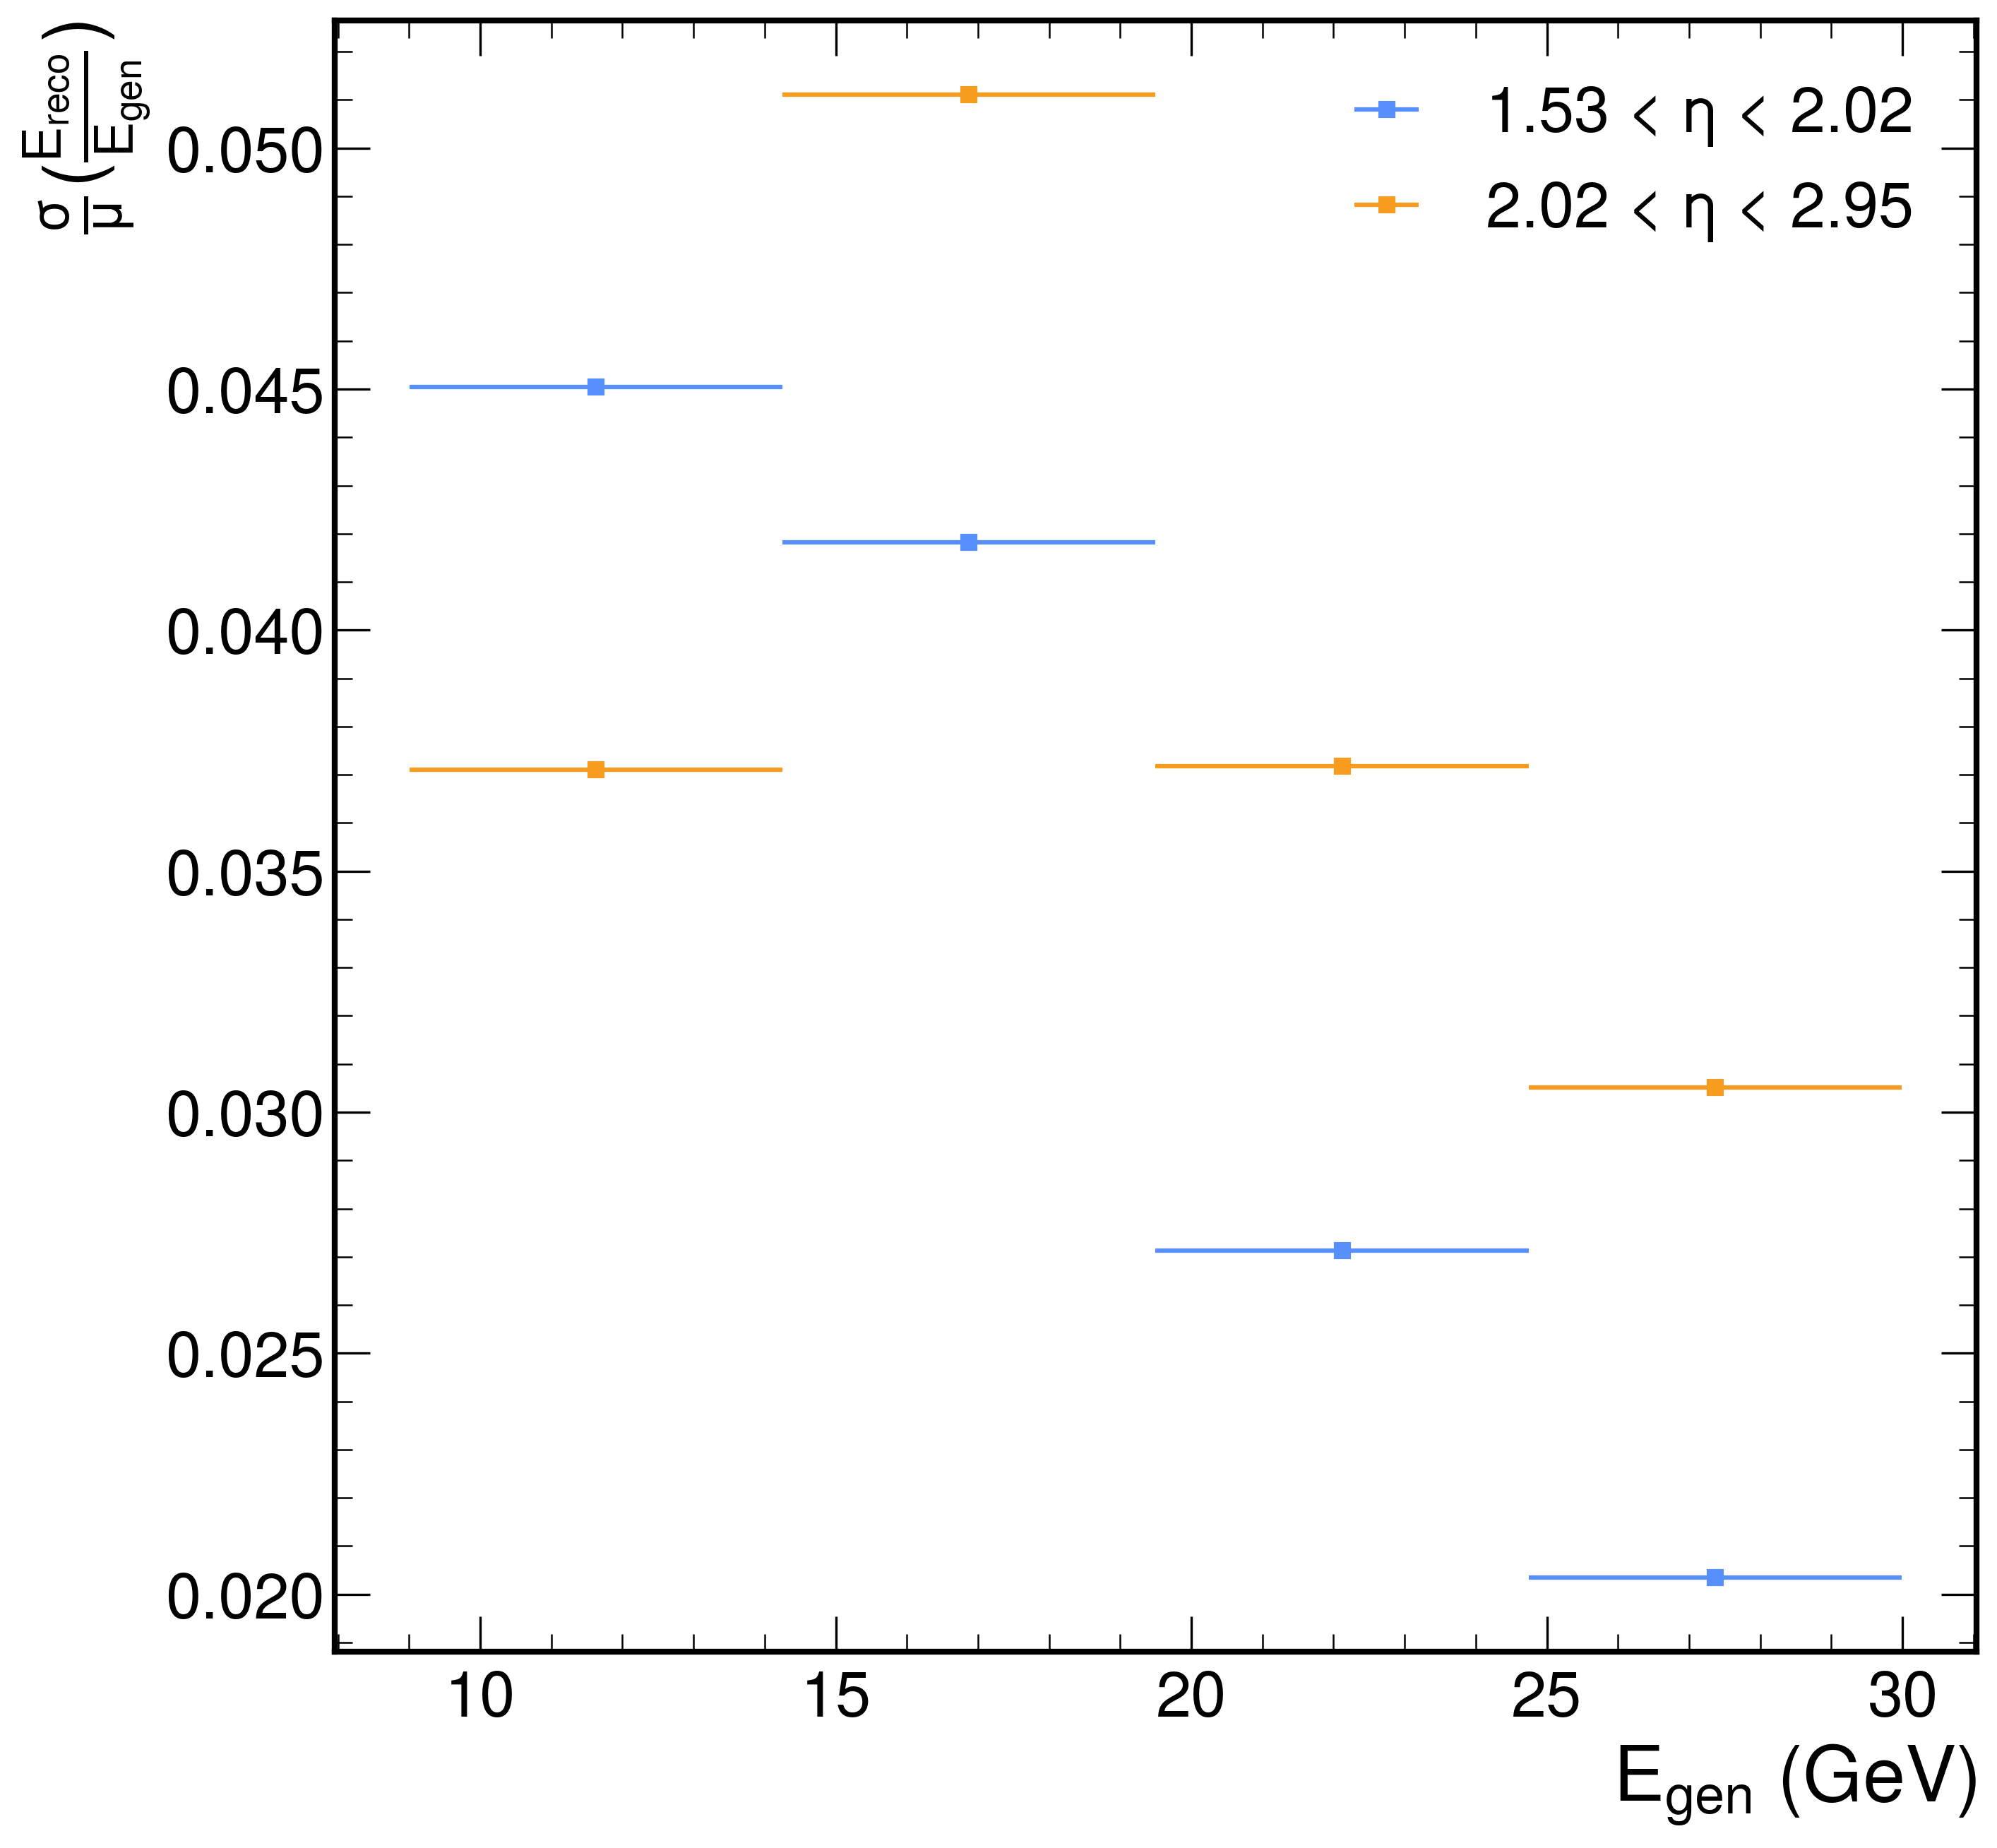

In [60]:
# sigma over mu plots
fig, ax = plt.subplots()

bin_edges = hists_hd[2]
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
bin_width = (bin_edges[1:] - bin_edges[:-1])/2

eta_min = np.min(barycenter_eta)
eta_max = np.max(barycenter_eta)
label_hd = rf'{eta_min:.2f} < $\eta$ < 2.02'
label_ld = rf'2.02 < $\eta$ < {eta_max:.2f}'

ax.errorbar(bin_centers, resolution_hd, xerr = bin_width, ls='none', fmt='s', markersize=5, label=label_hd)
ax.errorbar(bin_centers, resolution_ld, xerr = bin_width, ls='none', fmt='s', markersize=5, label=label_ld)
ax.set_xlabel(r'$E_\text{gen}$ (GeV)')
ax.set_ylabel(r'$\frac{\sigma}{\mu}(\frac{E_\text{reco}}{E_\text{gen}})$')
ax.legend()

hist_name = 'res_HD_LD_comparison'
path_to_save = 'plots/resolution/'
os.makedirs(path_to_save, exist_ok=True)
plt.savefig(f'{path_to_save}/{hist_name}.png')

In [97]:
# total number of events in histograms
histograms = hists_hd[0]
n_events = []
for histogram in histograms:
    n_events.append(np.sum(histogram))

In [100]:
n_events

[np.int64(469), np.int64(486), np.int64(512), np.int64(429)]

# Energy response

Energy response is a ratio between energy of a reconstructed object and energy of simulated one which corresponds to it.

$
\begin{equation}
    \text{Response} = \frac{E_\text{reco}^i}{E_\text{gen}^i}
\end{equation}
$

One needs to plot it in bins of $E_\text{gen}$.

First, extract energy arrays of generated and reconstructed objects. Second, do gen-matching by applying `recoToSim_CP_score < 1` condition. Third, using simToReco_CP extract best matched reco object to each sim one.

In [3]:
e_gen = ak.flatten(tfile.openArray(branch_name="ticlDumper/simtrackstersCP", key="raw_energy"))
e_reco = tfile.openArray(branch_name="ticlDumper/trackstersCLUE3DHigh", key="raw_energy")


In [6]:
simToReco = tfile.openArray(branch_name="ticlDumper/associations", key="tsCLUE3D_simToReco_CP")[:, 0]

In [5]:
response = e_reco[simToReco][:, 0]/e_gen

response_cutted = response[(e_gen > 5) & (e_gen < 30)]

In [6]:
e_gen_c = e_gen[(e_gen > 5) & (e_gen < 30)]
e_gen_bin_edges = np.logspace(np.log10(np.min(e_gen_c)), np.log10(np.max(e_gen_c)), 10)

In [7]:
# Make a list of energy response values for each E_gen bin
response_in_e_gen_bins = []
for bin in range(len(e_gen_bin_edges) - 1):
    bin_map = (e_gen > e_gen_bin_edges[bin]) & (e_gen < e_gen_bin_edges[bin + 1])
    response_in_e_gen_bins.append(response[bin_map])

In [8]:
# Make a histogram for each response array
response_histograms = []
resp_bins = np.linspace(0, 1, 15)
for response in response_in_e_gen_bins:
    histogram, bin_edges = np.histogram(np.array(response), resp_bins)
    response_histograms.append(histogram)

In [ ]:
import matplotlib.pyplot as plt

resp_bins = np.linspace(0, 1, 15)

for bin in range(len(e_gen_bin_edges) - 1):
    fig, ax = plt.subplots()
    bin_label = f'{e_gen_bin_edges[bin]} < e_gen < {e_gen_bin_edges[bin + 1]}'
    ax.hist(response_in_e_gen_bins[bin], resp_bins, label = bin_label)
    ax.legend()

In [46]:
bins = np.linspace(0, 1, 20)

(array([200., 281., 342., 422., 479., 612., 736., 887., 901.]),
 array([ 5.01317978,  6.11559153,  7.46042633,  9.1009922 , 11.10232639,
        13.54375648, 16.52206039, 20.15530396, 24.58750916, 29.9943676 ]),
 <BarContainer object of 9 artists>)

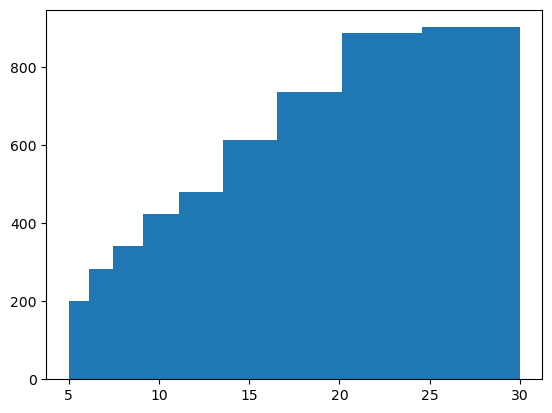

In [74]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(e_gen, e_gen_bin_edges)
#ax.set_yscale('log')
#ax.set_xbound(0, 1)